Data importation:
We import the packages needed and the datasets to use

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
categories_df=pd.read_json("categories.json")
products=pd.read_json("products.json")

In [2]:
categories_df.head(5)

,id,name,path,subCategories
0,abcat0010000,Gift Ideas,"[{'id': 'abcat0010000', 'name': 'Gift Ideas'}]","[{'id': 'pcmcat140000050035', 'name': 'Capturi..."
1,abcat0020001,Learning Toys,"[{'id': 'abcat0010000', 'name': 'Gift Ideas'},...",[]
2,abcat0020002,DVD Games,"[{'id': 'abcat0010000', 'name': 'Gift Ideas'},...",[]
3,abcat0020004,Unique Gifts,"[{'id': 'abcat0010000', 'name': 'Gift Ideas'},...",[]
4,abcat0100000,TV & Home Theater,"[{'id': 'abcat0100000', 'name': 'TV & Home The...","[{'id': 'abcat0101000', 'name': 'TVs'}, {'id':..."


In [3]:
products.head(50)

,sku,name,type,price,upc,category,shipping,description,manufacturer,model,url,image
0,43900,Duracell - AAA Batteries (4-Pack),HardGood,5.49,41333424019,"[{'id': 'pcmcat312300050015', 'name': 'Connect...",5.49,Compatible with select electronic devices; AAA...,Duracell,MN2400B4Z,http://www.bestbuy.com/site/duracell-aaa-batte...,http://img.bbystatic.com/BestBuy_US/images/pro...
1,48530,Duracell - AA 1.5V CopperTop Batteries (4-Pack),HardGood,5.49,41333415017,"[{'id': 'pcmcat312300050015', 'name': 'Connect...",5.49,Long-lasting energy; DURALOCK Power Preserve t...,Duracell,MN1500B4Z,http://www.bestbuy.com/site/duracell-aa-1-5v-c...,http://img.bbystatic.com/BestBuy_US/images/pro...
2,127687,Duracell - AA Batteries (8-Pack),HardGood,7.49,41333825014,"[{'id': 'pcmcat312300050015', 'name': 'Connect...",5.49,Compatible with select electronic devices; AA ...,Duracell,MN1500B8Z,http://www.bestbuy.com/site/duracell-aa-batter...,http://img.bbystatic.com/BestBuy_US/images/pro...
3,150115,Energizer - MAX Batteries AA (4-Pack),HardGood,4.99,39800011329,"[{'id': 'pcmcat312300050015', 'name': 'Connect...",5.49,4-pack AA alkaline batteries; battery tester i...,Energizer,E91BP-4,http://www.bestbuy.com/site/energizer-max-batt...,http://img.bbystatic.com/BestBuy_US/images/pro...
4,185230,Duracell - C Batteries (4-Pack),HardGood,8.99,41333440019,"[{'id': 'pcmcat312300050015', 'name': 'Connect...",5.49,Compatible with select electronic devices; C s...,Duracell,MN1400R4Z,http://www.bestbuy.com/site/duracell-c-batteri...,http://img.bbystatic.com/BestBuy_US/images/pro...
5,185267,Duracell - D Batteries (4-Pack),HardGood,9.99,41333430010,"[{'id': 'pcmcat312300050015', 'name': 'Connect...",5.99,Compatible with select electronic devices; D s...,Duracell,MN1300R4Z,http://www.bestbuy.com/site/duracell-d-batteri...,http://img.bbystatic.com/BestBuy_US/images/pro...
6,312290,Duracell - 9V Batteries (2-Pack),HardGood,7.99,41333216010,"[{'id': 'pcmcat312300050015', 'name': 'Connect...",5.49,Compatible with select electronic devices; alk...,Duracell,MN1604B2Z,http://www.bestbuy.com/site/duracell-9v-batter...,http://img.bbystatic.com/BestBuy_US/images/pro...
7,324884,Directed Electronics - Viper Audio Glass Break...,HardGood,39.99,93207005060,"[{'id': 'pcmcat113100050015', 'name': 'Carfi I...",0,From our expanded online assortment; compatibl...,Directed Electronics,506T,http://www.bestbuy.com/site/directed-electroni...,http://img.bbystatic.com/BestBuy_US/images/pro...
8,333179,Energizer - N Cell E90 Batteries (2-Pack),HardGood,5.99,39800013200,"[{'id': 'pcmcat312300050015', 'name': 'Connect...",5.49,Alkaline batteries; 1.5V,Energizer,E90BP-2,http://www.bestbuy.com/site/energizer-n-cell-e...,http://img.bbystatic.com/BestBuy_US/images/pro...
9,346575,Metra - Radio Installation Dash Kit for Most 1...,HardGood,16.99,86429002757,"[{'id': 'abcat0300000', 'name': 'Car Electroni...",0,From our expanded online assortment; compatibl...,Metra,99-5512,http://www.bestbuy.com/site/metra-radio-instal...,http://img.bbystatic.com/BestBuy_US/images/pro...


We will set the features to be the X from now and the labels to be the y

In [4]:
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

new_category_list=[]
for x in products.category:
    new_category_list.append(list(x[-1].values())[1])

products.category=new_category_list
y = products.category
enc = OrdinalEncoder(dtype='int')
y = np.array(y)
enc.fit(y.reshape(-1,1))
aux = enc.transform(y.reshape(-1,1))
aux=pd.DataFrame(aux)

new_categories=[]
threshold=32
values=aux.value_counts().values
indexes=aux.value_counts().index

for x,y in zip(indexes,values):
    if y > threshold:
        new_categories.append(x[0])
    else:
        new_categories.append('other')

new_y=[]
for category in aux.values:
    if category[0] in new_categories:
        new_y.append(category[0])
    else:
        new_y.append('other')

X = products.drop(['category'], axis=1)
y = new_y
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)

In [18]:
categories_list=[]
for category in new_y:
    if type(category)!=str:
        label=enc.categories_[0][category]
        if label not in categories_list:
            categories_list.append(label)
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
np.array(categories_list)

array(['Alkaline Batteries', 'Specialty Batteries',
       'Dash Installation Kits', 'Deck Harnesses', 'Antennas & Adapters',
       'Cordless Phone Batteries', 'Car Subwoofers',
       'Sound Recording Software', 'Music Memorabilia',
       'Keyboard Accessories', 'More Pop Culture Merchandise',
       'Audio Interfaces', 'Microphones', 'DJ Equipment Accessories',
       'Recording & Music Stands', 'Sheet Music', 'Wii Games',
       'DSLR Body & Lens', 'Xbox 360 Games', 'Action Camcorder Mounts',
       'DJ Lighting & Effects', 'Battery Backup (UPS)', 'Pre-Owned Games',
       'Powersports Audio', 'Monitor & Video Cables', 'Cooktops',
       'All Headphones', 'Coffee Pods', 'Single-Serve Blenders',
       'Upright Freezers', 'Projector Screens', 'Power Supplies',
       'Hair Dryers', 'Over-Ear Headphones', 'Accessories',
       'Nintendo DS Games', 'PCI Express Graphics Cards', 'PS3 Games',
       'TV Mounts', 'Condenser', 'Prime Lenses',
       'Laptop Chargers & Adapters', 'Window 

In [5]:
import pickle
pickle.dump(enc, open(b"encoder.pkl","wb"))


Now we create some classes to be used as esential parts in a future pipeline

In [6]:
import nltk
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\frodr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\frodr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\frodr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from utils import Word2VecProcessor, FastTextProcessor, DropColumns, ColumnExtractor, MyOneHotEncoding, NameDescriptionImputation, NameDescriptionNormalization, TfidfVectorizerTransformer, OrdinalEncoding
pd.options.mode.chained_assignment = None
import pickle

# Transformers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

# Modeling Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report
from IPython.display import display, Markdown

# Pipelines
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

#liraries for NLP
import os
import sys
# I had some issues importing files
# This is how I addressed them:
cwd = os.getcwd()
add = "/".join(cwd.split("/")[:-1])
sys.path.append(add)

from text_normalizer import normalize_corpus
from sklearn.feature_extraction.text import TfidfVectorizer


COLS_TO_DROP = ['sku','upc', 'shipping','manufacturer', 'model', 'url', 'image']
pipe = Pipeline([
    ('drop columns', DropColumns(COLS_TO_DROP)),
    ('features', FeatureUnion([
        ('price', Pipeline([
            ('extract', ColumnExtractor(["price"])),
            ('imputation', SimpleImputer(strategy="mean")),
            ('scaler', StandardScaler())
        ])),
        ('type', Pipeline([
            ('extract', ColumnExtractor(["type"])),
            ('imputation', SimpleImputer(strategy="most_frequent")),
            ('ohe', OneHotEncoder(drop='first'))
        ])),
        ('name and description', Pipeline([
            ('extract', ColumnExtractor(["name","description"])),#"description"])),
            ('imputation', NameDescriptionImputation()),
            ('text normalizer', NameDescriptionNormalization()),    
            ('text vectorizer', TfidfVectorizerTransformer())
        ]))
    ]))
])


pipe_name = Pipeline([
        ('name and description', Pipeline([
            ('extract', ColumnExtractor(["name","description"])),#"description"])),
            ('imputation', NameDescriptionImputation()),
            ('text normalizer', NameDescriptionNormalization()),    
            #('text word2vec', Word2VecProcessor()) #('text vectorizer', TfidfVectorizerTransformer())
            ('text vectorizer', TfidfVectorizerTransformer())
        ]))
])

pipeline_for_predict=Pipeline([
        ('name and description', Pipeline([
            ('imputation', NameDescriptionImputation()),
            ('text normalizer', NameDescriptionNormalization()),    
            ('text vectorizer', TfidfVectorizerTransformer())
        ]))
])

In [8]:
pipe_name.fit(X_train, y_train)

X_train1=pipe_name.transform(X_train)
X_test1=pipe_name.transform(X_test)

#pipeline_for_predict.fit(X_train, y_train)

In [9]:
a={'name':'AA Bateries','description':'Bateries for all uses'}
test = pd.DataFrame([a])
test
pipe_name.transform(test)

<1x14827 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [10]:
import pickle
filehandler = open(b"pipeline_name.pkl","wb")
pickle.dump(pipe_name,filehandler)

In [11]:
filehandler2=open(b"pipeline_name.pkl","rb")
pipeline_new=pickle.load(filehandler2)
a=pipeline_new.transform(X_test)
a

<15494x14827 sparse matrix of type '<class 'numpy.float64'>'
	with 105820 stored elements in Compressed Sparse Row format>

In [12]:
pipe.fit_transform(X_train, y_train)

X_train=pipe.transform(X_train)
X_test=pipe.transform(X_test)

In [26]:
from sklearn.ensemble import RandomForestClassifier
#import wandb

labels=list(enc.get_params())
#wandb.init(project="my-test-project")

cl_rf = RandomForestClassifier(n_jobs=-1)
cl_rf.fit(X_train1, y_train)
y_preds = cl_rf.predict(X_test1)
y_probas=cl_rf.predict_proba(X_test1)
f1_score(y_test, y_preds, average="weighted")
micro=f1_score(y_test, y_preds, average=None)

#wandb.sklearn.plot_classifier(cl_rf, X_train, X_test, y_train, y_test, y_preds, y_probas,labels=labels, model_name="SVC", feature_names=None)

In [27]:
f1_score(y_test, y_preds, average="weighted")

0.8317883016659766

In [13]:
from sklearn.neighbors import KNeighborsClassifier
KNN_model = KNeighborsClassifier(n_neighbors=3).fit(X_train1, y_train)
KNN_pred = KNN_model.predict(X_test1)  
print(f1_score(y_test, KNN_pred, average="weighted"))

0.7372579233423867


In [16]:
proba=KNN_model.predict_proba(X_test1)

In [11]:
"""max_value=proba[3].max()
max(list(proba[3]))
list_proba=list(proba)
list_proba.index(max_value)"""

enc.categories_[0][1]


'2-Way Speakers'

In [20]:

pickle.dump(KNN_model,open(b"KNN_model.pkl","wb"))

#filehandler2=open(b"pipeline_name.pkl","rb")
#pipeline_new=pickle.load(filehandler2)
#a=pipeline_new.transform(X_test)
new_knn=pickle.load(open(b"KNN_model.pkl","rb"))
a=new_knn.predict(X_test1)
a

array(['other', '881', '101', ..., '400', '1427', '997'], dtype='<U11')

In [30]:
import xgboost as xgb

bst = xgb.XGBClassifier(n_estimators=100, max_depth=200, learning_rate=1, objective='multi:softprob')
# fit model
bst.fit(X_train1, y_train)
# make predictions
preds = bst.predict(X_test1)

micro = f1_score(y_test, preds, average="micro")
sns.distplot(micro)
print(f1_score(y_test, preds, average="weighted"))

c:\Users\frodr\anaconda3\lib\site-packages\xgboost\sklearn.py:1464: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or not (self.classes_ == expected_classes).all()


AttributeError: 'bool' object has no attribute 'all'

In [12]:
from sklearn.neighbors import KNeighborsClassifier
KNN_model = KNeighborsClassifier(n_neighbors=3).fit(X_train1, y_train)
KNN_pred = KNN_model.predict(X_test1)  
f1_score(y_test, KNN_pred, average="weighted")

0.7376066207882696

In [13]:
from sklearn.svm import LinearSVC
svm_model = LinearSVC(max_iter=3000).fit(X_train1, y_train)
svm_pred = svm_model.predict(X_test1)  
f1_score(y_test, svm_pred, average="weighted")

KeyboardInterrupt: 

In [14]:
#Current parameters of Random Forest
cl_rf.get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [25]:

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [50,100, 200,300,400,500,600]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [1,2,5,10,20,50]

# Minimum number of samples required to split a node
min_samples_split = [1,2, 5, 10, 20, None]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, None]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)


{'n_estimators': [50, 100, 200, 300, 400, 500, 600], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 2, 5, 10, 20, 50], 'min_samples_split': [1, 2, 5, 10, 20, None], 'min_samples_leaf': [1, 2, 4, None], 'bootstrap': [True, False]}


In [17]:

%%time
print("")


CPU times: user 186 µs, sys: 5 µs, total: 191 µs
Wall time: 144 µs


In [27]:

%%time
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 40, cv = 3, verbose=2, random_state=42, n_jobs = 2)
# Fit the random search model
rf_random.fit(X_train1, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.24789807 0.30460283        nan        nan
 0.54129781 0.30850306        nan        nan        nan 0.30742416
        nan        nan        nan        nan        nan 0.24186735
        nan        nan        nan 0.44025229 0.26028979        nan
        nan        nan        nan        nan        nan 0.24894908
        nan 0.31835038        nan 0.43845421 0.20095707 0.20095707
 0.25525511        nan 0.40133318        nan]
  category=UserWarning


CPU times: user 1min 57s, sys: 1.36 s, total: 1min 58s
Wall time: 13min 30s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=40,
                   n_jobs=2,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 2, 5, 10, 20, 50],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, None],
                                        'min_samples_split': [1, 2, 5, 10, 20,
                                                              None],
                                        'n_estimators': [50, 100, 200, 300, 400,
                                                         500, 600]},
                   random_state=42, verbose=2)

In [29]:
print(rf_random.best_params_)

"""{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}"""

{'n_estimators': 600, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': False}


"{'bootstrap': True,\n 'ccp_alpha': 0.0,\n 'class_weight': None,\n 'criterion': 'gini',\n 'max_depth': None,\n 'max_features': 'auto',\n 'max_leaf_nodes': None,\n 'max_samples': None,\n 'min_impurity_decrease': 0.0,\n 'min_impurity_split': None,\n 'min_samples_leaf': 1,\n 'min_samples_split': 2,\n 'min_weight_fraction_leaf': 0.0,\n 'n_estimators': 100,\n 'n_jobs': -1,\n 'oob_score': False,\n 'random_state': None,\n 'verbose': 0,\n 'warm_start': False}"

0.4607957067954689


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

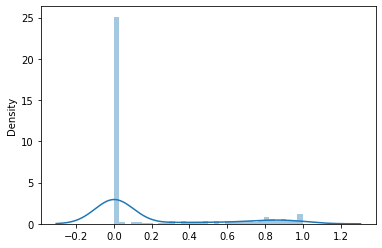

In [30]:
preds = rf_random.predict(X_test)
f1=f1_score(y_test, preds, average="weighted")
print(f1)
micro = f1_score(y_test, preds, average=None)
sns.distplot(micro)

In [33]:
from sklearn.model_selection import GridSearchCV

gs_clf=GridSearchCV(rf,random_grid, n_jobs=2)
gs_clf.fit(X_train1, y_train)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: 

In [19]:
import joblib 
model = joblib.load('C:/Users/frodr/Downloads/clf.pkl')
